In [46]:
!pip install -q -r Requirements.txt

### Loading and exploring data

In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [48]:
df = pd.read_csv('Data/Processed/ChurnModelling_Binning_Applied.csv')
df.head()

,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreBins
0,France,Female,3.76120,2,0.00,1,1,1,101348.88,1,Fair
1,Spain,Female,3.73767,1,83807.86,1,0,1,112542.58,0,Fair
2,France,Female,3.76120,8,159660.80,3,1,0,113931.57,1,Poor
3,France,Female,3.68668,1,0.00,2,0,0,93826.63,0,Good
4,Spain,Female,3.78419,2,125510.82,1,1,1,79084.10,0,Excellent


### 2. Build Scikit-Learn Pipeline

In [49]:
numerical_features = ['Age', 'Tenure', 'Balance', 'EstimatedSalary']
nominal_features = ['Geography', 'Gender']
ordinal_features = ['CreditScoreBins']
remainder_features = ['HasCrCard', 'IsActiveMember', 'Exited', 'NumOfProducts']

numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
    
) 

nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant',
                                  fill_value = 'missing')),
        ('encoder', OneHotEncoder())
    ]
    
)

ordinal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant',
                                  fill_value = 'missing')),
        ('encoder', OrdinalEncoder())
    ]
    
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)
    ],
    remainder='drop'
)

nominal_feature_names =[]
for feature in nominal_features:
    unique_values = df[feature].unique()
    # print(unique_values)
    nominal_feature_names.extend([f"{feature}_{val}" for val in unique_values])

# nominal_feature_names

df_cp = df.copy()
df_transformed = pd.DataFrame(
    preprocessor.fit_transform(df_cp),
    columns= numerical_features + nominal_feature_names + ordinal_features
)

# df_transformed

df_remainder = df[remainder_features]
df_pp = pd.concat([df_transformed,df_remainder], axis=1)

df_pp

,Age,Tenure,Balance,EstimatedSalary,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male,CreditScoreBins,HasCrCard,IsActiveMember,Exited,NumOfProducts
0,0.428433,-1.041526,-1.225704,0.021852,1.0,0.0,0.0,1.0,0.0,1.0,1,1,1,1
1,0.332317,-1.387294,0.117331,0.216474,0.0,0.0,1.0,1.0,0.0,1.0,0,1,0,1
2,0.428433,1.033083,1.332886,0.240624,1.0,0.0,0.0,1.0,0.0,3.0,1,0,1,3
3,0.124038,-1.387294,-1.225704,-0.108935,1.0,0.0,0.0,1.0,0.0,2.0,0,0,0,2
4,0.522339,-1.041526,0.785627,-0.365260,0.0,0.0,1.0,1.0,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,0.133021,-0.004221,-1.225704,-0.066442,1.0,0.0,0.0,0.0,1.0,4.0,1,0,0,2
9989,-0.297349,1.724620,-0.306347,0.027953,1.0,0.0,0.0,0.0,1.0,3.0,1,1,0,1
9990,-0.185431,0.687315,-1.225704,-1.008543,1.0,0.0,0.0,1.0,0.0,2.0,0,1,1,1
9991,0.428433,-0.695758,-0.022610,-0.125246,0.0,1.0,0.0,0.0,1.0,4.0,1,0,1,2


In [50]:
df_pp.to_csv('data/processed/X_transformed.csv', index=False)

### 3. Handle Class Imbalances

In [51]:
X = df_pp.drop(columns=['Exited'])
Y = df_pp['Exited']

In [52]:
'''churn - 1000
non-churn - 9000

downsampling - (non-churn) 9000 -> 1000
upsampling - (churn) 1000 -> 9000'''

'''We split the test,train data before handling class imbalances because if we do it earlier the train and test data will have similar data'''

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42
)

In [53]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

Text(0, 0.5, 'Count')

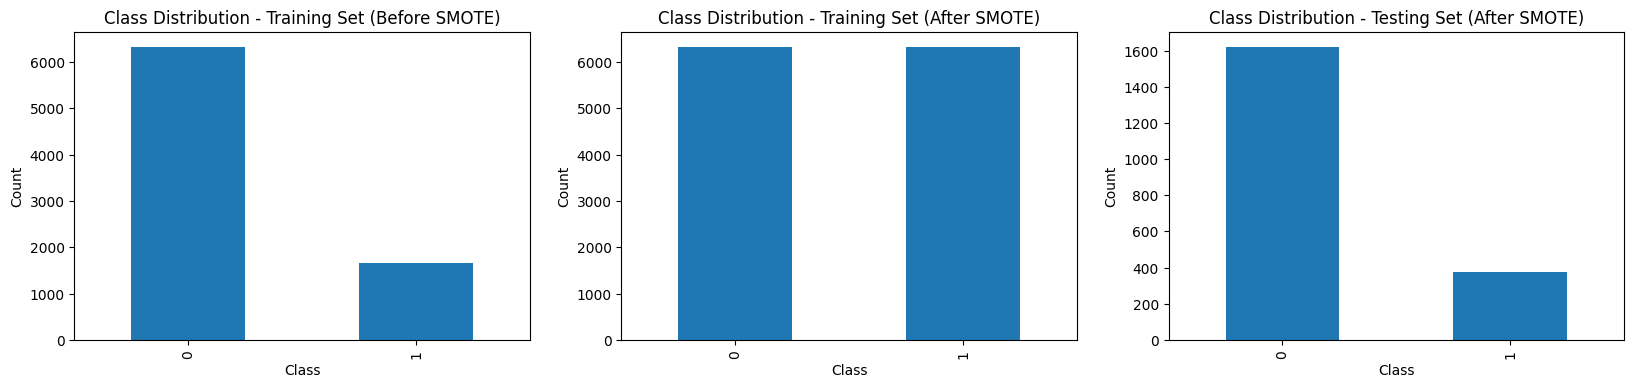

In [54]:
plt.figure(figsize=(20, 4))

plt.subplot(131)
Y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')


plt.subplot(132)
Y_train_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(133)
Y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution - Testing Set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')



In [55]:
np.savez('Artifacts/X_train.npz', X_train_resampled)
np.savez('Artifacts/Y_train.npz', Y_train_resampled)
np.savez('Artifacts/X_test.npz', X_test)
np.savez('Artifacts/Y_test.npz', Y_test)